Understanding the Impact of Missing Values
Missing values in a dataset can significantly affect the validity and accuracy of an analysis. In observational studies, missing data often arise due to nonresponse, dropout, or failures in data collection. Particularly in weight loss studies, participants might not consistently report their dietary intakes or weight due to personal reasons, leading to missingness.

Types of Missing Data
Missing Completely at Random (MCAR): The probability of missing data on a variable is the same for all observations.
Missing at Random (MAR): The probability of missing data depends on the observed data but not the missing data.
Missing Not at Random (MNAR): The probability of missing data depends on the value of the missing data itself.
Causal Implications of Missing Data
Missing data can bias the results unless properly addressed, particularly if the missingness is related to the outcome (e.g., weight loss) or the treatment (e.g., diet type). For instance, if individuals who do not lose weight are less likely to report their diet or weight, the analysis could erroneously amplify the effectiveness of the diet.

Causal Approach to Handle Missing Data
Imputation Techniques that Consider Causal Structure
To address this, we can use imputation techniques that incorporate the causal structure of the data:

Multiple Imputation: This method involves creating several different plausible imputations for the missing values. By incorporating variables that influence both the likelihood of missingness and the outcomes, we can reduce bias.
Causal Imputation: Here, the imputation model includes not only the predictors of missingness but also the variables that influence the outcome. This approach respects the underlying causal relationships and can lead to more accurate estimates of treatment effects.

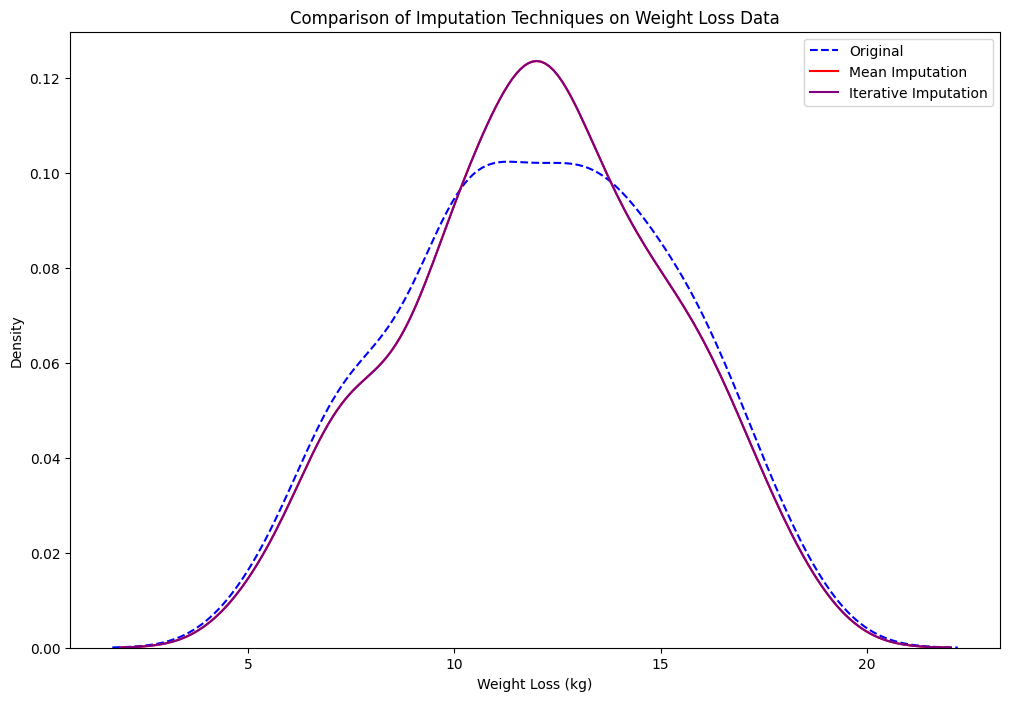

,Age,Diet,InitialWeight,WeightLoss,ActivityLevel,WeightLossMean,WeightLossIterative
0,58,High Protein,92,13.453744,Medium,13.453744,13.453744
1,48,Low Carb,99,13.614480,Medium,13.614480,13.614480
2,34,Low Carb,69,9.104307,Medium,9.104307,9.104307
3,27,High Protein,88,12.592286,Medium,12.592286,12.592286
4,40,High Protein,72,11.675184,High,11.675184,11.675184


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.experimental import enable_iterative_imputer  # for IterativeImputer

# Seed for reproducibility
np.random.seed(42)

# Create a DataFrame with 200 observations
data = pd.DataFrame({
    'Age': np.random.randint(20, 60, 200),
    'Diet': np.random.choice(['Low Carb', 'High Protein', 'Vegan'], 200, p=[0.3, 0.4, 0.3]),
    'InitialWeight': np.random.randint(60, 100, 200),
    'WeightLoss': np.random.randint(5, 15, 200) + np.random.rand(200) * 5,  # More realistic weight loss
    'ActivityLevel': np.random.choice(['Low', 'Medium', 'High'], 200, p=[0.2, 0.5, 0.3])
})

# Introduce missing values in 'WeightLoss' based on a MAR scenario
mask = (data['ActivityLevel'] == 'Low') & (np.random.rand(200) < 0.4)
data.loc[mask, 'WeightLoss'] = np.nan

### Imputation Techniques ###

# 1. Mean Imputation
mean_imputer = SimpleImputer(strategy='mean')
data['WeightLossMean'] = mean_imputer.fit_transform(data[['WeightLoss']])

# 2. Iterative Imputation
iterative_imputer = IterativeImputer(random_state=0)
data['WeightLossIterative'] = iterative_imputer.fit_transform(data[['WeightLoss']])

### Visualization of Imputation Effects ###

plt.figure(figsize=(12, 8))
sns.kdeplot(data['WeightLoss'], label='Original', linestyle='--', color='blue')
sns.kdeplot(data['WeightLossMean'], label='Mean Imputation', color='red')
sns.kdeplot(data['WeightLossIterative'], label='Iterative Imputation', color='purple')
plt.title('Comparison of Imputation Techniques on Weight Loss Data')
plt.xlabel('Weight Loss (kg)')
plt.ylabel('Density')
plt.legend()
plt.show()

data.head()



Analysis
* Mean Imputation tends to reduce the variance and may bias the mean weight loss.
* Regression Imputation might reflect more accurate trends but assumes a linear relationship.
* Iterative Imputation could provide the most balanced approach, reflecting both the mean and distribution while considering multiple variables in the dataset.

Conclusion

By visualizing these imputation methods, we can see how each impacts our understanding of the diet's effect on weight loss. Choosing the right imputation method is crucial to avoid bias in causal analysis. The iterative imputation, while complex, provides a more nuanced and potentially accurate representation of the missing data.

Yes, using a Causal Bayesian Network (CBN) for imputation in your analysis of the effect of diet on weight loss is a sophisticated and appropriate approach, especially when you're concerned with the causal relationships between variables. CBNs can be particularly powerful in scenarios where the data may be missing not at random (MNAR), as they allow for the explicit modeling of the dependencies between variables, including those dependencies that might lead to missing data.

How Causal Bayesian Networks Work for Imputation
A Causal Bayesian Network is a type of probabilistic graphical model that represents a set of variables and their conditional dependencies via a directed acyclic graph (DAG). For imputation:

Nodes represent variables (e.g., Age, Diet, InitialWeight, WeightLoss, ActivityLevel).
Directed edges indicate causal influences between the variables.
The network can be used to compute the joint probability distribution of the variables and to perform inference, thereby enabling the estimation of missing data based on the probabilistic relationships specified by the DAG.

Steps to Implement Causal Bayesian Network for Imputation
Define the Causal Structure: Draw on domain knowledge to define a plausible causal diagram that describes how different factors such as diet, age, initial weight, and activity level influence weight loss. This step is critical because the efficacy of the imputation heavily depends on the accuracy of the causal assumptions encoded in the network.
Parameter Estimation: Using the available data, estimate the conditional probability distributions for each node given its parents in the network. This typically involves statistical estimation techniques like maximum likelihood or Bayesian methods.
Imputation: For cases with missing data, use the network to perform probabilistic inference. This can be done using methods like belief propagation or Markov Chain Monte Carlo (MCMC) sampling to estimate the most likely values of the missing data given the observed data and the causal structure.
Validation: It's crucial to validate the assumptions and the performance of the network, especially the imputation accuracy. This might involve techniques like cross-validation or comparing the outcomes against other imputation methods.

In [22]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

# Discretizing 'WeightLoss' into three categories
def discretize_weight_loss(value):
    if pd.isna(value):
        return np.nan  # Preserve NaNs for imputation
    elif value < 10:
        return 'Low'
    elif value < 15:
        return 'Medium'
    else:
        return 'High'

data['DiscreteWeightLoss'] = data['WeightLoss'].apply(discretize_weight_loss)

# Updating the Bayesian Network to use the discretized weight loss
model = BayesianNetwork([
    ('Age', 'DiscreteWeightLoss'),
    ('InitialWeight', 'DiscreteWeightLoss'),
    ('Diet', 'DiscreteWeightLoss'),
    ('ActivityLevel', 'DiscreteWeightLoss')
])

model.fit(data.dropna(subset=['DiscreteWeightLoss']), estimator=MaximumLikelihoodEstimator)
inference = VariableElimination(model)
query = inference.query(variables=['DiscreteWeightLoss'], evidence={'Age': 45, 'InitialWeight': 85, 'Diet': 'Vegan', 'ActivityLevel': 'Medium'})
print(query)

+----------------------------+---------------------------+
| DiscreteWeightLoss         |   phi(DiscreteWeightLoss) |
+============================+===========================+
| DiscreteWeightLoss(High)   |                    0.3333 |
+----------------------------+---------------------------+
| DiscreteWeightLoss(Low)    |                    0.3333 |
+----------------------------+---------------------------+
| DiscreteWeightLoss(Medium) |                    0.3333 |
+----------------------------+---------------------------+


Using a Causal Bayesian Network for imputation allows you to leverage causal relationships, potentially leading to more accurate and meaningful imputation, especially in causal inference studies. However, the success of this approach hinges on the accuracy and completeness of the causal model you construct based on your domain knowledge and available data.

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

data_encoded = pd.get_dummies(data, columns=['Diet', 'ActivityLevel'])
data_encoded.head()

#Function to perform regression and calculate MSE
def analyze_imputed_data(column_name):
    model = LinearRegression()
    # Using non-missing data to fit the model
    features = [col for col in data_encoded.columns if col not in ['WeightLoss', 'WeightLossMean', 'WeightLossIterative']]
    X = data_encoded[features]
    y = data_encoded[column_name].dropna()
    X = X.loc[y.index]
    model.fit(X, y)
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)
    print(f"MSE for {column_name}: {mse}")

# Analyze each column
analyze_imputed_data('WeightLossMean')
analyze_imputed_data('WeightLossIterative')
data_encoded.head()

MSE for WeightLossMean: 8.955513022524006
MSE for WeightLossIterative: 8.955513022524006


,Age,InitialWeight,WeightLoss,WeightLossMean,WeightLossIterative,Diet_High Protein,Diet_Low Carb,Diet_Vegan,ActivityLevel_High,ActivityLevel_Low,ActivityLevel_Medium
0,58,92,13.453744,13.453744,13.453744,True,False,False,False,False,True
1,48,99,13.614480,13.614480,13.614480,False,True,False,False,False,True
2,34,69,9.104307,9.104307,9.104307,False,True,False,False,False,True
3,27,88,12.592286,12.592286,12.592286,True,False,False,False,False,True
4,40,72,11.675184,11.675184,11.675184,True,False,False,True,False,False


In [35]:
import pymc3 as pm

data = data.dropna(subset=['WeightLoss', 'WeightLossMean', 'WeightLossIterative'])  # Ensure data completeness

with pm.Model() as model:
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta_age = pm.Normal('beta_age', mu=0, sigma=10)
    beta_initial_weight = pm.Normal('beta_initial_weight', mu=0, sigma=10)

    # Convert categorical variables to numeric for PyMC3
    diet_encoded = pd.Categorical(data['Diet']).codes
    activity_level_encoded = pd.Categorical(data['ActivityLevel']).codes

    # Likelihood (sampling distribution) of observations
    weight_loss = pm.Normal('WeightLoss', mu=alpha + beta_age * data['Age'] 
                            + beta_initial_weight * data['InitialWeight'], 
                            sigma=1, observed=data['WeightLoss'])

    # Posterior distribution
    trace = pm.sample(500)

    # Querying the posterior
    age_value = 45
    initial_weight_value = 85
    predicted_weight_loss = alpha + beta_age * age_value + beta_initial_weight * initial_weight_value
    print(pm.summary(trace, var_names=['alpha', 'beta_age', 'beta_initial_weight']))
    print("Predicted Weight Loss:", pm.sample_posterior_predictive(trace, samples=50, model=model)[predicted_weight_loss])

AttributeError: partially initialized module 'theano' has no attribute 'compile' (most likely due to a circular import)